In [1]:
"""
Multi-Channel Speech Presence Probability
==============

----------


.. [1] M. Souden, J. Chen, J. Benesty and S. Affes, "Gaussian Model-Based Multichannel Speech Presence Probability,"
    in IEEE Transactions on Audio, Speech, and Language Processing, vol. 18, no. 5, pp. 1072-1077, July 2010,
    doi: 10.1109/TASL.2009.2035150.
   [2] Bagheri, S., Giacobello, D. (2019) Exploiting Multi-Channel Speech Presence Probability in Parametric
    Multi-Channel Wiener Filter. Proc. Interspeech 2019, 101-105, DOI: 10.21437/Interspeech.2019-2665

"""

import os

import numpy as np
from scipy.signal import convolve
import soundfile as sf
from pesq import pesq
from pystoi.stoi import stoi
import IPython.display as ipd

from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.ArraySim import ArraySim

from DistantSpeech.noise_estimation.mcra import NoiseEstimationMCRA
from DistantSpeech.transform.transform import Transform
from DistantSpeech.beamformer.utils import pmesh, load_wav, save_audio, load_pcm

In [2]:
class McSppBase(object):
    def __init__(self, nfft=256, channels=4) -> None:
        super().__init__()

        self.channels = channels

        self.nfft = nfft
        self.half_bin = int(self.nfft / 2 + 1)
        self.lambda_d = np.zeros(self.half_bin)
        self.alpha_d = 0.95

        self.alpha = 0.92

        self.alpha_s = 0.8
        self.delta_s = 5
        self.alpha_p = 0.2

        self.ell = 1
        self.b = [0.25, 0.5, 0.25]

        self.S = np.zeros(self.half_bin)
        self.Smin = np.zeros(self.half_bin)
        self.Stmp = np.zeros(self.half_bin)
        self.q = np.ones(self.half_bin) * 0.6
        self.p = np.zeros(self.half_bin)
        self.alpha_tilde = np.zeros(self.half_bin)
        self.G_H1 = np.zeros(self.half_bin)
        self.G = np.zeros(self.half_bin)

        self.Phi_yy = np.zeros((self.channels, self.channels, self.half_bin))
        self.Phi_vv = np.zeros((self.channels, self.channels, self.half_bin))
        self.Phi_vv_inv = np.zeros((self.channels, self.channels, self.half_bin))
        self.Phi_xx = np.zeros((self.channels, self.channels, self.half_bin))

        self.psd_yy = np.zeros((self.half_bin, self.channels, self.channels), dtype=np.complex128)

        self.xi = np.zeros(self.half_bin)
        self.gamma = np.zeros(self.half_bin)
        self.L = 125

        self.win = np.array([0.25, 0.5, 0.25])
        self.alpha_s = 0.8

        self.diagonal_eps = np.eye(self.channels)*1e-6

        self.mcra = NoiseEstimationMCRA(nfft=self.nfft)

        self.frm_cnt = 0

    def estimate_psd(self, y, alpha):
        pass

    def estimate_noisy_psd(self, y, alpha):
        # [F,C] *[F,C]->[F,C,C]
        self.psd_yy = np.einsum('ij,il->ijl', y.conj(), y)
        # smooth
        self.Phi_yy = self.alpha * self.Phi_yy + (1 - self.alpha) * np.real(np.transpose(self.psd_yy, (1, 2, 0)))

    def compute_posterior_snr(self, y):
        pass

    def compute_prior_snr(self, y):
        pass

    def compute_q(self, y, q_max=0.99, q_min=0.01):

        self.mcra.estimation(np.abs(y[:, 0] * np.conj(y[:, 0])))

        self.q = np.sqrt(1 - self.mcra.p/2)
        self.q = np.minimum(np.maximum(self.q, q_min), q_max)

        return self.q

    def compute_p(self, p_max=1.0, p_min=0.0):
        """
        compute posterior speech presence probability
        :param p_max:
        :param p_min:
        :return:
        """
        self.p = 1 / (1 + self.q / (1 - self.q) * (1 + self.xi) * np.exp(-1 * (self.gamma / (1 + self.xi))))
        self.p = np.minimum(np.maximum(self.p, p_min), p_max)

    def compute_weight(self, xi, Gmin=0.0631):
        self.G_H1 = self.xi / (1 + self.xi)
        self.G = np.power(self.G_H1, self.p) * np.power(Gmin, (1 - self.p))
        self.G = np.maximum(np.minimum(self.G, 1), Gmin)
        self.G[:2] = 0

    def smooth_psd(self, x, previous_x, win, alpha):
        """
        smooth spectrum in frequency and time
        :param x: current x
        :param previous_x: last time x
        :param win: smooth window
        :param alpha: smooth factor
        :return: smoothed x
        """
        w = len(win)

        # smoothing in frequency
        smoothed_f = convolve(x, win)
        smoothed_f_val = smoothed_f[int((w - 1) / 2):int(-((w - 1) / 2))]

        # smoothing in time
        smoothed_x = alpha * previous_x + (1 - alpha) * smoothed_f_val

        return smoothed_x

    def estimation(self, y):

        self.estimate_noisy_psd(y, self.alpha)

        self.Phi_xx = self.Phi_yy - self.Phi_vv

        for k in range(self.half_bin):
            # if self.frm_cnt < 10:
            #     self.Phi_vv[:, :, k] = self.Phi_yy[:, :, k]

            Phi_vv_inv = np.linalg.inv(self.Phi_vv[:, :, k] + self.diagonal_eps)
            # Phi_vv_inv = self.Phi_vv[:, :, k]

            self.xi[k] = np.trace(Phi_vv_inv @ self.Phi_yy[:, :, k]) - self.channels

            self.gamma[k] = np.real(y[k:k+1, :] @ Phi_vv_inv @ self.Phi_xx[:, :, k] @ Phi_vv_inv @ y[k:k+1, :].conj().T)

        self.xi = np.minimum(np.maximum(self.xi, 1e-6), 100.0)
        self.gamma = np.minimum(np.maximum(self.gamma, 1e-6), 1000.0)

        self.compute_q(y)
        self.compute_p(p_max=0.99, p_min=0.01)
        self.update_noise_psd(y, beta=1.0)
        self.compute_weight(self.xi)

        self.frm_cnt = self.frm_cnt + 1

    def update_noise_psd(self, y: np.ndarray, beta=1.0):
        """
        update noise PSD using spp
        :param y: complex noisy signal vector, [half_bin, channel]
        :param beta:
        :return:
        """
        self.alpha_tilde = self.alpha_d + (1 - self.alpha_d) * self.p  # eq 5,

        # eq.17 in [1]
        for k in range(self.half_bin):
            self.Phi_vv[:, :, k] = np.real(self.alpha_tilde[k] * self.Phi_vv[:, :, k] + beta *
                                           (1 - self.alpha_tilde[k]) * (self.psd_yy[k, :, :]))


def main(args):

    signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav")
    noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/babble.wav")
    fs = 16000
    mic_array = ArraySim(array_type="linear", spacing=0.05)
    array_data, premix = mic_array.generate_audio(signal)
    print(array_data.shape)

    # filepath = "test_audio/p232/"              # [u1,u2,u3,y]
    # # filepath = "./test_audio/rec1_mcra_gsc/"     # [y,u1,u2,u3]
    # x, sr = load_wav(os.path.abspath(filepath))  # [channel, samples]
    # audio_file = 'test_audio/SSB19180462#noise-free-sound-0665#4.70_3.93_3.00_2.46_1.72_218.8051_42.3619_0.3466#-2#3.4485138549309093#0.5211135715489874.wav'
    # wave_data, sr = sf.read(os.path.abspath(audio_file)) # (frames x channels)
    # x = wave_data.transpose()
    # sr = 16000
    # r = 0.032
    # c = 343

    # frameLen = 256
    # hop = frameLen / 2
    # overlap = frameLen - hop
    # nfft = 256
    # c = 340
    # r = 0.032
    # fs = sr

    # print(x.shape)
    # channel = x.shape[0]

    # transform = Transform(n_fft=512, hop_length=256, channel=channel)

    # D = transform.stft(x.transpose())     # [F,T,Ch]
    # Y, _ = transform.magphase(D, 2)
    # print(Y.shape)
    # # pmesh(librosa.power_to_db(Y[:, :, -1]))
    # # plt.savefig('pmesh.png')

    # mcspp = McSppBase(nfft=512, channels=channel)
    # noise_psd = np.zeros((Y.shape[0], Y.shape[1]))
    # p = np.zeros((Y.shape[0], Y.shape[1]))
    # Yout = np.zeros((Y.shape[0], Y.shape[1]), dtype=type(Y))
    # y = np.zeros(x.shape[1])

    # start = time.process_time()

    # for n in range(Y.shape[1]):
    #     mcspp.estimation(D[:, n, :])
    #     p[:, n] = mcspp.p
    #     Yout[:, n] = D[:, n, 0] * mcspp.G

    # end = time.process_time()
    # print(end - start)

    # y = transform.istft(Yout)

    # if args.eval:
    #     ref_path = os.path.abspath(os.path.join(root_path, 'ref', audio_file))
    #     ref, sr = sf.read(ref_path)
    #     assert fs == sr
    #     if len(ref.shape) >= 2:
    #         ref = ref[:, 0]

    #     nsy = wave_data[:, 0]
    #     enh = y[256:]
    #     nsy = nsy[:len(enh)]
    #     ref = ref[:len(enh)]

    #     summary = {'ref_pesq': pesq(sr, ref, nsy, 'wb'),
    #                'enh_pesq': pesq(sr, ref, enh, 'wb'),
    #                'ref_stoi': stoi(ref, nsy, sr, extended=False),
    #                'enh_stoi': stoi(ref, enh, sr, extended=False),
    #                'ref_estoi': stoi(ref, nsy, sr, extended=True),
    #                'enh_estoi': stoi(ref, enh, sr, extended=True)}
    #     for key in summary.keys():
    #         print('{}:{}'.format(key, summary[key]))

    # # pmesh(librosa.power_to_db(noise_psd))
    # # plt.savefig('noise_psd.png')

    # # pmesh(p)
    # # plt.savefig('p.png')
    # #
    # # plt.plot(y)
    # # plt.show()

    # # save audio
    # if args.save:
    #     audio = (y * np.iinfo(np.int16).max).astype(np.int16)
    #     wavfile.write('./output_mcsppbase_p232_3.wav', 16000, audio)


The RT60 is 110 ms
(3, 201674)
(2, 3, 203610)


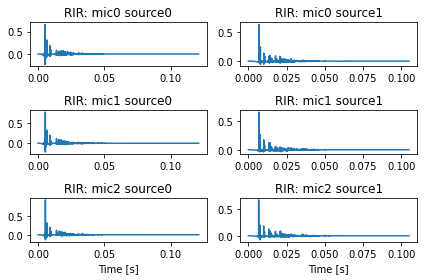

In [131]:
from DistantSpeech.beamformer.utils import pmesh, load_wav
from matplotlib import pyplot as plt
import librosa
import time
from scipy.io import wavfile

signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3_2.wav")
noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office1.wav")
fs = 16000
M = 3
mic_array = ArraySim(array_type="linear", spacing=0.05, M=M)
array_data, premix = mic_array.generate_audio(signal, interference=noise, source_angle=120, sir=10, snr=30)
print(array_data.shape)
print(premix.shape)

(257, 790, 3)
(257, 787, 3)


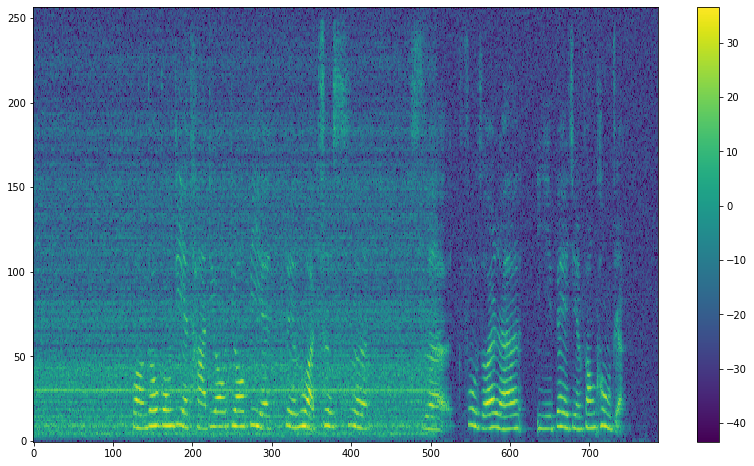

In [132]:

sr = 16000
r = 0.032
c = 343

frameLen = 256
hop = frameLen / 2
overlap = frameLen - hop
nfft = 256
c = 340
r = 0.032
fs = sr

# pampath = '/home/wangwei/work/DistantSpeech/samples/bookself/1'
# # pampath = '/home/wangwei/work/corpus/kws/lanso/record_test/meetingroom/20220106/pcm'
# array_data = load_pcm(pampath)


transform = Transform(n_fft=512, hop_length=256, channel=M)
D = transform.stft(np.transpose(array_data))
Noise = transform.stft(np.transpose(premix[1, ...]))

D = D[:, :790, :]
Noise = Noise[:, :790, :]
print(Noise.shape)
Y, _ = transform.magphase(D, 2)
print(Y.shape)
pmesh(librosa.power_to_db(Y[:, :, 0]))
# audiowrite('audio.wav', np.transpose(array_data))
# audiowrite('signal.wav', np.transpose(premix[0, :, :]))
# audiowrite('interf.wav', np.transpose(premix[1, :, :]))

In [133]:
channel = M
mcspp = McSppBase(nfft=512, channels=channel)
mcspp.mcra.L = 15

[-4.23183489+0.69441706j -3.47650576-1.14222801j -1.36904764-2.03633618j]
[[18.39064158+0.j         13.91881574+7.24786524j  4.37951699+9.56812854j]
 [13.91881574-7.24786524j 13.39077709+0.j          7.08546223+5.5155699j ]
 [ 4.37951699-9.56812854j  7.08546223-5.5155699j   6.0209565 +0.j        ]]


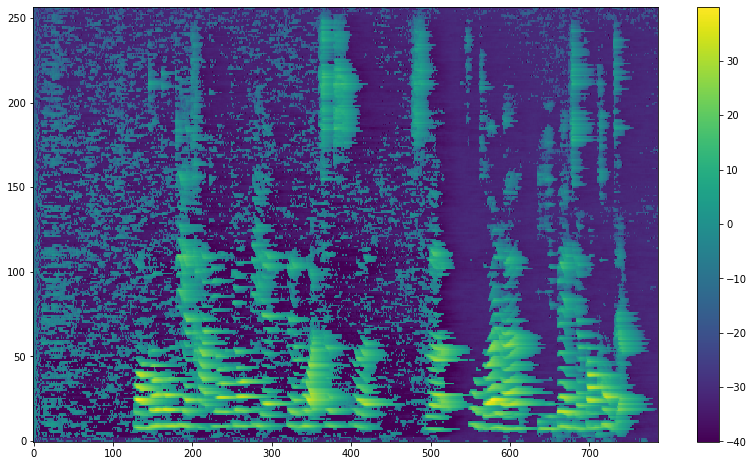

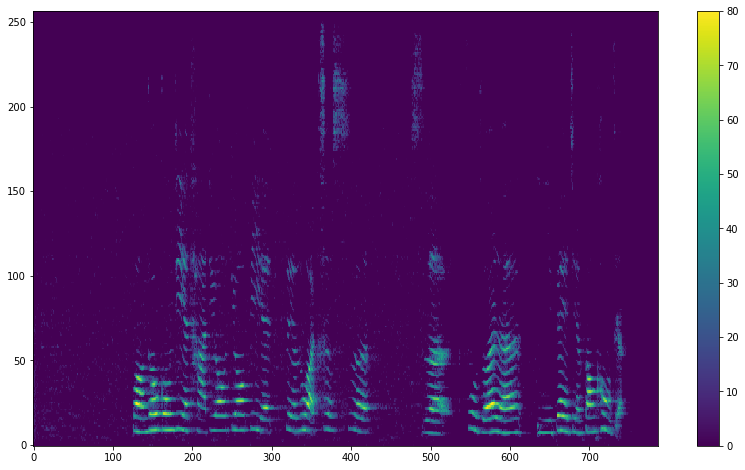

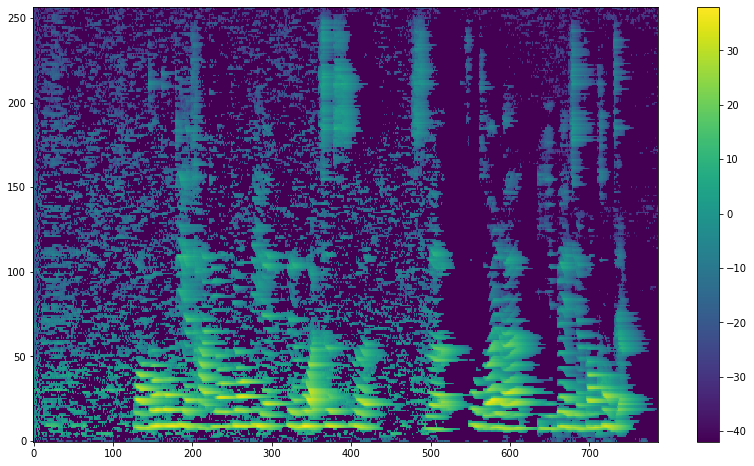

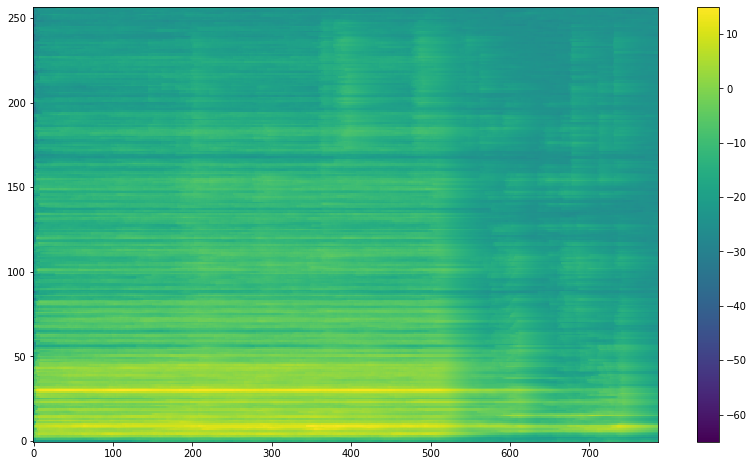

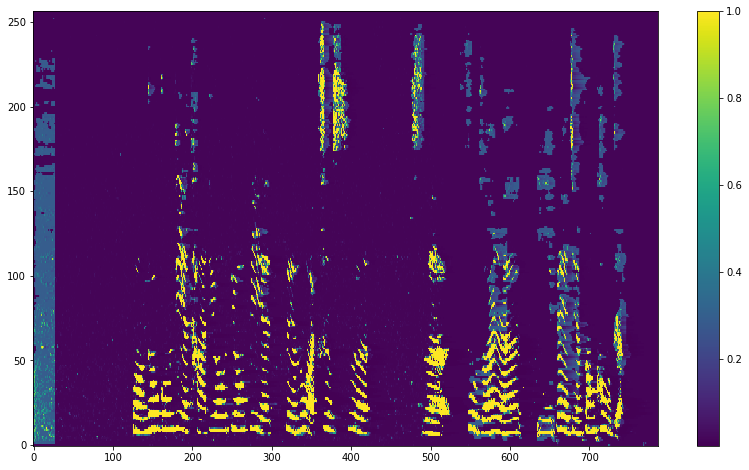

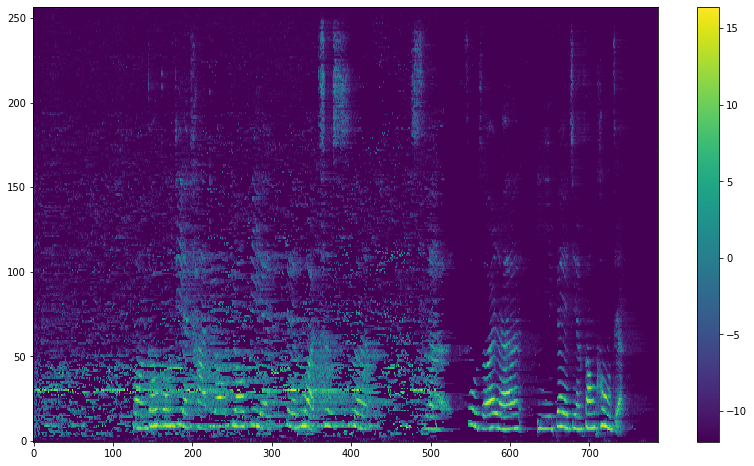

In [145]:
noise_psd = np.zeros((Y.shape[0], Y.shape[1]))
p = np.zeros((Y.shape[0], Y.shape[1]))
Yout = np.zeros((Y.shape[0], Y.shape[1]), dtype=complex)
# y = np.zeros(x.shape[1])

# start = time.process_time()
half_bin = 257
Phi_yy = np.zeros((M, M, half_bin), dtype=complex)
Phi_vv = np.zeros((M, M, half_bin), dtype=complex)
Phi_xx = np.zeros((M, M, half_bin), dtype=complex)

w = np.zeros((M, half_bin), dtype=complex)

Phi_xx_all = np.zeros((Y.shape[0], Y.shape[1]))
Phi_vv_all = np.zeros((Y.shape[0], Y.shape[1]))

# Phi_yy = np.zeros((M, M, 257))
# Phi_vv = np.zeros((M, M, 257))
# Phi_xx = np.zeros((M, M, 257))

xi = np.zeros((half_bin, Y.shape[1]))
beta = np.zeros((half_bin, Y.shape[1]))
p = np.zeros((half_bin, Y.shape[1]))
glr = np.zeros((half_bin, Y.shape[1]))
q = np.ones(half_bin) * 0.6
# [F,C] *[F,C]->[F,C,C]
# psd_yy = 
# psd_yy = np.einsum('ij,il->ijl', y.conj(), y)
# # smooth
# self.Phi_yy = self.alpha * self.Phi_yy + (1 - self.alpha) * np.real(np.transpose(self.psd_yy, (1, 2, 0)))

known_noise_sample = False
alpha_yy = 0.85
alpha_vv = 0.15
alpha_d = 0.95
for n in range(Y.shape[1]):
    y = D[:, n, :]


    q = mcspp.compute_q(y)

    psd_yy = np.einsum('ij,il->ijl', y.conj(), y)

    if n == 200:
        print(y[32, :])
        print(psd_yy[32, :, :])
    Phi_yy = alpha_yy * Phi_yy + (1 - alpha_yy) * (np.transpose(psd_yy, (1, 2, 0)))

    if n == 0:
        Phi_vv = Phi_yy

    if known_noise_sample:
        noise = Noise[:, n, :] # [M, half_bin]
        psd_vv = np.einsum('ij,il->ijl', noise.conj(), noise)
        Phi_vv = alpha_vv * Phi_vv + (1 - alpha_vv) * (np.transpose(psd_vv, (1, 2, 0))) # [M,M,half_bin]
    Phi_xx = Phi_yy - Phi_vv
    if n < 10:
        Phi_vv = Phi_yy
    # else:
    #     Phi_xx = Phi_yy - Phi_vv
    diag_snr = 10
    
    for k in range(half_bin):
        # if n>100:
        #     noise_floor = np.real(Phi_vv[0, 0, k])/(10**(diag_snr/10))+1e-6
        # else:
        #     noise_floor = 1e-3
        noise_floor = 1e-1

        # print(Phi_vv[0, 0, k])
        # print(noise_floor)
        Phi_xx_all[k, n] = np.real(np.trace((Phi_xx[:, :, k])))
        if Phi_xx_all[k, n]< 1e-6:
            Phi_xx[:, :, k] = np.eye(M) * 1e-6
            Phi_vv_inv = np.linalg.inv(Phi_yy[:, :, k] + np.eye(M) * 1e-3)
        else:
            Phi_vv_inv = np.linalg.inv(Phi_vv[:, :, k] + np.eye(M) * noise_floor)
        xi[k, n] = np.real(np.trace(Phi_xx[:, :, k] @ Phi_vv_inv))
        if xi[k, n]< 0:
            Phi_vv_inv = np.linalg.inv(Phi_yy[:, :, k] + np.eye(M) * 1e-3)
        else:
            Phi_vv_inv = np.linalg.inv(Phi_vv[:, :, k] + np.eye(M) * noise_floor)
        xi[k, n] = np.minimum(np.maximum(xi[k, n], 1e-6),1e8)
        beta[k, n] = np.abs(y[k:k+1, :] @ Phi_vv_inv @ Phi_xx[:, :, k] @ Phi_vv_inv @ y[k:k+1, :].conj().T)
        beta[k, n] = np.minimum(np.maximum(beta[k, n], 1e-6),1e8)
        p[k, n] = 1 / (1 + q[k] / (1 - q[k]) * (1 + xi[k, n]) * np.exp(-1 * (beta[k, n] / (1 + xi[k, n]))))

        u = np.zeros((M, 1))
        u[0, 0] = 1
        w[:, k : k + 1] = Phi_vv_inv @ Phi_xx[:, :, k] @ u / (1+xi[k,n])
        Yout[k, n] = D[k:k+1, n, :] @ w[:, k:k+1].conj()

    alpha_tilde = alpha_d + (1 - alpha_d) * p[:, n]  # eq 5,

    if not known_noise_sample:
        # # eq.17 in [1]
        for k in range(half_bin):
            Phi_vv[:, :, k] = alpha_tilde[k] * Phi_vv[:, :, k] + (1 - alpha_tilde[k]) * (psd_yy[k, :, :])
            Phi_vv_all[k, n] = np.real(Phi_vv[0, 0, k])
    # # mcspp.estimation(D[:, n, :])
    # # p[:, n] = mcspp.p
    # # Yout[:, n] = D[:, n, 0] * mcspp.G

    # Phi_xx = Phi_yy - Phi_vv
    
    # # # if n < 110:
    # # #     Phi_vv = Phi_yy
    # # # else:
    # # #     Phi_xx = Phi_yy - Phi_vv
    
    # # 10**(30/10)
    # for k in range(half_bin):
    #     Phi_xx_all[k, n] = np.real(np.trace((Phi_xx[:, :, k])))
    #     # noise_floor = Phi_vv[0, 0, k]/(10**(diag_snr/10))
    #     if Phi_xx_all[k, n]< 0:
    #         # print('{} {} {}'.format(k,n, Phi_xx_all[k, n]))
    #         Phi_vv_inv = np.linalg.inv(Phi_yy[:, :, k] + np.eye(M) * 1e-3)
    #     else:
    #         Phi_vv_inv = np.linalg.inv(Phi_vv[:, :, k] + np.eye(M) * noise_floor)
    #     # if n<2:
    #     #     Phi_vv_inv = np.linalg.inv(Phi_vv[:, :, k] + np.eye(M) * 1e-6)
    #     # else:
    #     #     Phi_vv_inv = np.linalg.inv(Phi_vv[:,:,k])
    #     # Phi_vv_inv = np.linalg.inv(Phi_vv[:,:,k])
    #     # xi[k, n] = np.real(np.trace(Phi_xx[:, :, k] @ Phi_vv_inv))
    #     xi[k, n] = np.real(np.trace(Phi_yy[:, :, k] @ Phi_vv_inv))-M
    #     xi[k, n] = np.minimum(np.maximum(xi[k, n], 1e-6),1e6)
    #     beta[k, n] = np.abs(y[k:k+1, :] @ Phi_vv_inv @ Phi_xx[:, :, k] @ Phi_vv_inv @ y[k:k+1, :].conj().T)
    #     beta[k, n] = np.minimum(np.maximum(beta[k, n], 1e-6),1e6)
    #     p[k, n] = 1 / (1 + q[k] / (1 - q[k]) * (1 + xi[k, n]) * np.exp(-1 * (beta[k, n] / (1 + xi[k, n]))))


pmesh(librosa.power_to_db(xi))
pmesh(librosa.power_to_db(beta))
pmesh(librosa.power_to_db(Phi_xx_all))
pmesh(librosa.power_to_db(Phi_vv_all))
pmesh(p)
pmesh(librosa.power_to_db(np.abs(Yout)+0.063))

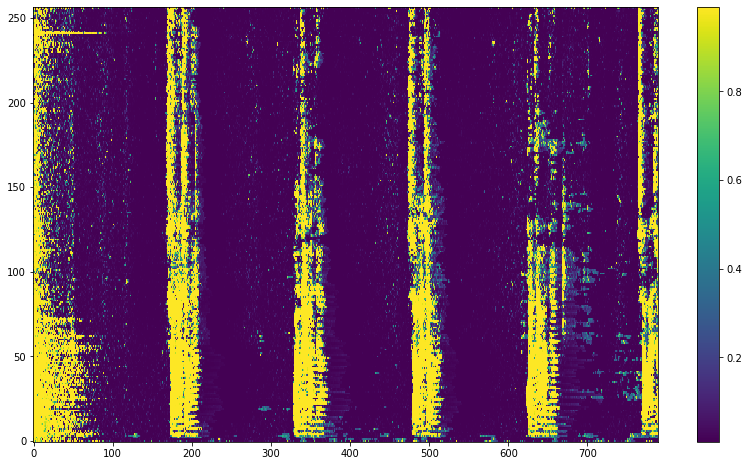

In [17]:
gamma = np.zeros((half_bin, Y.shape[1]))
for n in range(Y.shape[1]):
    mcspp.estimation(D[:, n, :])
    p[:, n] = mcspp.p
    gamma[:, n] = mcspp.gamma
    Yout[:, n] = D[:, n, 0] * mcspp.G
pmesh(p)
# pmesh(gamma)